In [173]:
import pandas as pd
import numpy as np
import numpy as np
import warnings
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [174]:
from math import sqrt
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [175]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

warnings.filterwarnings("ignore")


In [176]:
data = pd.read_csv("historical_data.csv")
data=data.dropna()
data["created_at"] = pd.to_datetime(data["created_at"])
data["actual_delivery_time"] = pd.to_datetime(data["actual_delivery_time"])


In [177]:
numeric_cols = data.select_dtypes(include='number').columns
data = data[data[numeric_cols].ge(0).all(axis=1)]

In [178]:
data["Delivery_time"] = data["actual_delivery_time"] - data["created_at"]
data["Delivery_time"] = data["Delivery_time"].dt.total_seconds()
data = data.drop(columns=["actual_delivery_time"])

In [179]:
data["Created_hour"] = data["created_at"].dt.hour
conditions = [
    (data['Created_hour'] >= 0) & (data['Created_hour'] < 6),
    (data['Created_hour'] >= 6) & (data['Created_hour'] < 12),
    (data['Created_hour'] >= 12) & (data['Created_hour'] < 19),
    (data['Created_hour'] >= 19) & (data['Created_hour'] <= 23),
]

labels = ['Late_Night', 'Morning', 'Afternoon', 'Night']

data['TimeOfDay'] = np.select(conditions, labels, default='Unknown')

In [180]:
a = [ 'total_items',"total_busy_dashers","total_onshift_dashers", "estimated_order_place_duration","estimated_store_to_consumer_driving_duration", 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_outstanding_orders','Delivery_time']
z_scores = stats.zscore(data[a])
threshold =3
outliers= (abs(z_scores)> threshold).any(axis=1)
df=data[~outliers]

In [181]:
df_dummies = pd.get_dummies(df['TimeOfDay'], prefix='TimeOfDay')
df = pd.concat([df, df_dummies], axis=1)

In [182]:
df = df.drop(columns="TimeOfDay")

In [183]:
df['TimeOfDay_Afternoon'] = df['TimeOfDay_Afternoon'].astype(int)
df['TimeOfDay_Late_Night'] = df['TimeOfDay_Late_Night'].astype(int)
df['TimeOfDay_Morning'] = df['TimeOfDay_Morning'].astype(int)
df['TimeOfDay_Night'] = df['TimeOfDay_Night'].astype(int)


In [184]:
df = df.drop(columns=["created_at","store_id","Created_hour","num_distinct_items","total_busy_dashers"])

In [185]:
train_set,test_set = train_test_split(df,test_size=0.2,random_state= 508)

In [186]:
mean_target = train_set.groupby('order_protocol')['Delivery_time'].mean()
train_set['order_protocol'] = train_set['order_protocol'].map(mean_target)

mean_target = train_set.groupby('store_primary_category')['Delivery_time'].mean()
train_set['store_primary_category'] = train_set['store_primary_category'].map(mean_target)

mean_target = train_set.groupby('market_id')['Delivery_time'].mean()
train_set['market_id'] = train_set['market_id'].map(mean_target)

In [187]:
mean_target = test_set.groupby('order_protocol')['Delivery_time'].mean()
test_set['order_protocol'] = test_set['order_protocol'].map(mean_target)

mean_target = test_set.groupby('store_primary_category')['Delivery_time'].mean()
test_set['store_primary_category'] = test_set['store_primary_category'].map(mean_target)

mean_target = test_set.groupby('market_id')['Delivery_time'].mean()
test_set['market_id'] = test_set['market_id'].map(mean_target)

In [188]:

X_train = train_set.drop('Delivery_time', axis=1)
X_test = test_set.drop('Delivery_time', axis=1)
y_train = train_set['Delivery_time']
y_test = test_set["Delivery_time"]

In [189]:
def custom_accuracy(y_true, y_pred):
    return np.sum(y_pred > y_true) / len(y_true)

def scatter_plot(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred)
    plt.title(f"{model_name} - Actual vs. Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

def residual_plot(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, color="g", alpha=0.5)
    plt.title(f"{model_name} - Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

def feature_importance_plot(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_importance = np.argsort(importance)
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_importance)), importance[feature_importance], align='center')
        plt.yticks(range(len(feature_importance)), [feature_names[i] for i in feature_importance])
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('Random Forest - Feature Importance')
        plt.show()

def scatter_pcr_plot(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, color="g", alpha=0.5)
    plt.title("PCR - Actual vs. Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

def scatter_lr_lasso_plot(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred)
    plt.title(f"{model_name} - Actual vs. Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

def scree_plot(pca):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title('Scree Plot for PCA')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

results_list = []



In [190]:
def calculate_metrics(y_test,rf_pred_test):
    rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
    r2 = r2_score(y_test, rf_pred_test)
    custom_acc = custom_accuracy(y_test, rf_pred_test)
    return rmse, r2, custom_acc

In [191]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred_test = linear_model.predict(X_test)
linear_pred_train = linear_model.predict(X_train)

In [192]:
rmse_test, r2_test, custom_acc_test = calculate_metrics(y_test, linear_pred_test)
rmse_train, r2_train, custom_acc_train = calculate_metrics(y_train, linear_pred_train)

In [193]:
print(f"""'Model': {linear_model},
        'RMSE Test': {rmse_test},
        'R2 Test': {r2_test},
        'Custom Accuracy Test': {custom_acc_test}                 
        'RMSE Train': {rmse_train},
        'R2 Train': {r2_train},
        'Custom Accuracy Train': {custom_acc_train}""")

'Model': LinearRegression(),
        'RMSE Test': 884.5824147191514,
        'R2 Test': 0.25673193706588104,
        'Custom Accuracy Test': 0.5809815012994954                 
        'RMSE Train': 882.138908275956,
        'R2 Train': 0.2553448349508344,
        'Custom Accuracy Train': 0.5735678576342705


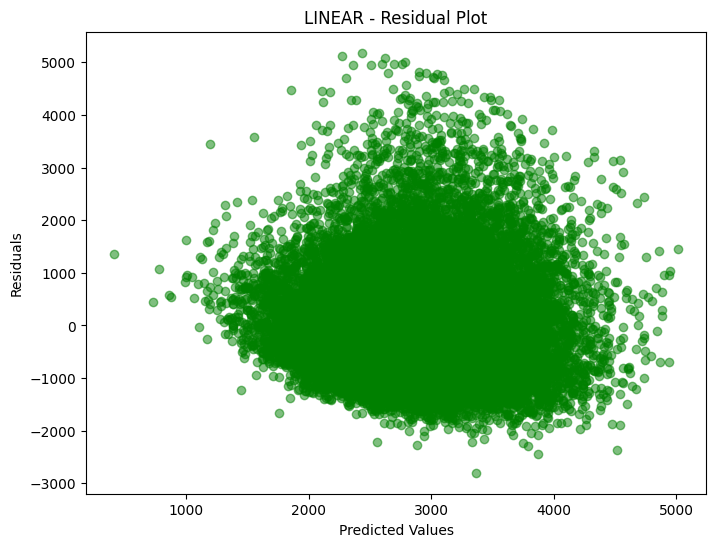

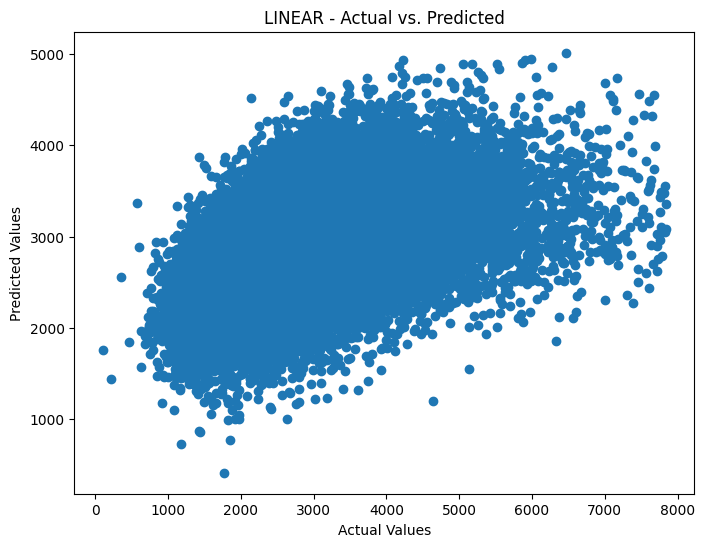

In [194]:
residual_plot(y_test, linear_pred_test, "LINEAR")
scatter_lr_lasso_plot(y_test, linear_pred_test, "LINEAR")

In [195]:
rf_model = RandomForestRegressor(n_estimators=60,random_state=609)
rf_model.fit(X_train, y_train)
rf_pred_test = rf_model.predict(X_test)
rf_pred_train = rf_model.predict(X_train)  

In [196]:
rmse_test, r2_test, custom_acc_test = calculate_metrics(y_test, rf_pred_test)
rmse_train, r2_train, custom_acc_train = calculate_metrics(y_train, rf_pred_train)

In [197]:
print(f"""'Model': {rf_model},
        'RMSE Test': {rmse_test},
        'R2 Test': {r2_test},
        'Custom Accuracy Test': {custom_acc_test}                 
        'RMSE Train': {rmse_train},
        'R2 Train': {r2_train},
        'Custom Accuracy Train': {custom_acc_train}""")

'Model': RandomForestRegressor(n_estimators=60, random_state=609),
        'RMSE Test': 870.4679982330598,
        'R2 Test': 0.2802619081570533,
        'Custom Accuracy Test': 0.5860571778015594                 
        'RMSE Train': 328.1524283048495,
        'R2 Train': 0.8969536779980416,
        'Custom Accuracy Train': 0.5795303398614869


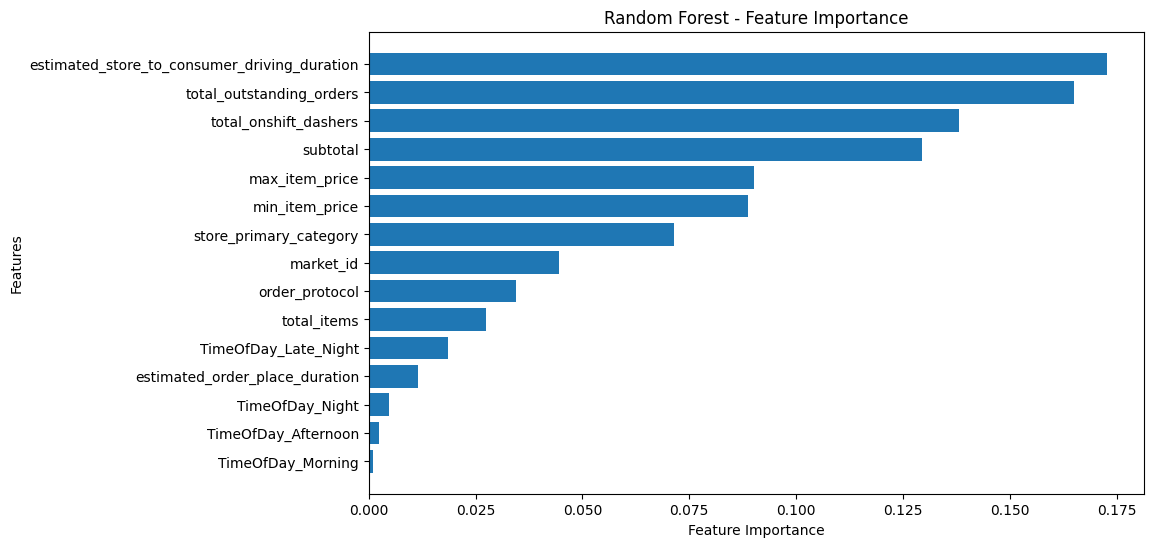

In [198]:
feature_importance_plot(rf_model, X_train.columns)


In [199]:
lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train, y_train)
lasso_pred_test = lasso_model.predict(X_test)
lasso_pred_train = lasso_model.predict(X_train)

In [200]:
rmse_test, r2_test, custom_acc_test = calculate_metrics(y_test, lasso_pred_test)
rmse_train, r2_train, custom_acc_train = calculate_metrics(y_train, lasso_pred_train)

In [201]:
print(f"""'Model': {lasso_model},
        'RMSE Test': {rmse_test},
        'R2 Test': {r2_test},
        'Custom Accuracy Test': {custom_acc_test}                 
        'RMSE Train': {rmse_train},
        'R2 Train': {r2_train},
        'Custom Accuracy Train': {custom_acc_train}""")

'Model': Lasso(alpha=1),
        'RMSE Test': 884.702186390547,
        'R2 Test': 0.25653064777165135,
        'Custom Accuracy Test': 0.5809815012994954                 
        'RMSE Train': 882.2139359073369,
        'R2 Train': 0.2552181608213545,
        'Custom Accuracy Train': 0.5735449250103197


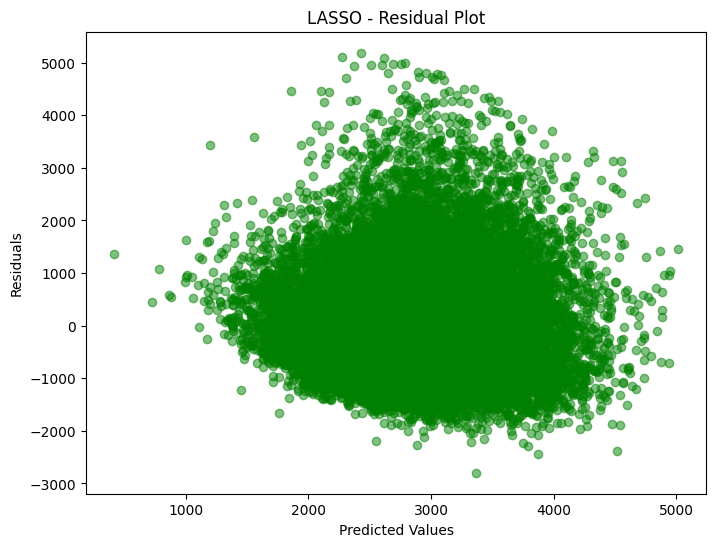

In [202]:
residual_plot(y_test, lasso_pred_test, "LASSO")

In [203]:
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso_model.coef_})
print(coefficients)

                                         Feature  Coefficient
0                                      market_id     0.995963
1                         store_primary_category     0.392051
2                                 order_protocol     0.835231
3                                    total_items    15.192897
4                                       subtotal     0.071680
5                                 min_item_price    -0.034918
6                                 max_item_price     0.059589
7                          total_onshift_dashers   -25.574273
8                       total_outstanding_orders    19.550454
9                 estimated_order_place_duration     0.326201
10  estimated_store_to_consumer_driving_duration     1.166534
11                           TimeOfDay_Afternoon     0.000000
12                          TimeOfDay_Late_Night   190.692685
13                             TimeOfDay_Morning    -0.000000
14                               TimeOfDay_Night    -0.000000


R-squared: 0.31753244661612656 0.34246978091686286
Root Mean Squared Error: 847.6304886559114 828.9288084353045


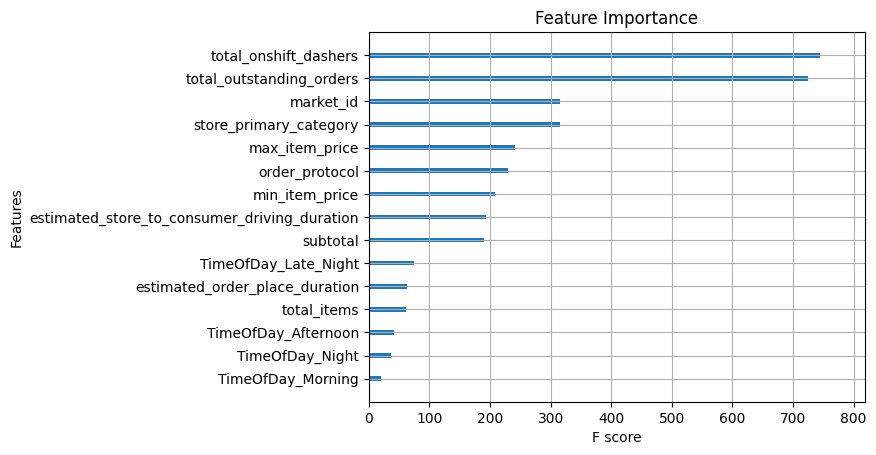

0.5573153951995108


In [204]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',  # for regression tasks
    'max_depth': 3,
    'learning_rate': 0.1,
}


model = xgb.XGBRegressor(**params, n_estimators=500)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
predictions_train = model.predict(X_train)

r2 = r2_score(y_test, predictions)
r2_test = r2_score(y_train,predictions_train)
print(f'R-squared: {r2}',r2_test)

rmse = mean_squared_error(y_test, predictions, squared=False)
rmse_1 =  mean_squared_error(y_train,predictions_train)
print(f'Root Mean Squared Error: {rmse}',sqrt(rmse_1))

xgb.plot_importance(model, importance_type='weight', show_values=False)
plt.title('Feature Importance')
plt.show()

print(np.sum(predictions >= y_test) / len(y_test))


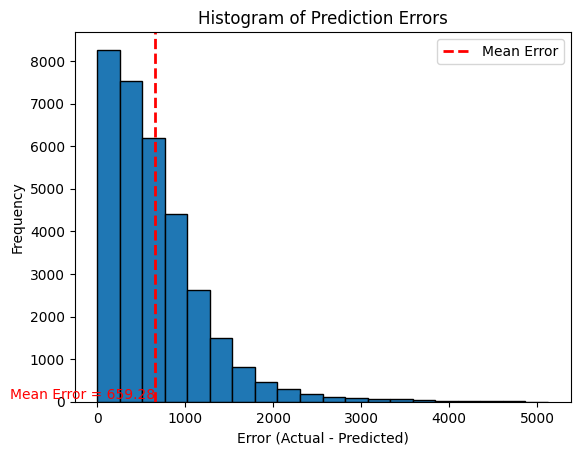

In [205]:
errors =abs( y_test - rf_pred_test)
mean_error = np.mean(errors)
plt.hist(errors, bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.axvline(x=mean_error, color='red', linestyle='dashed', linewidth=2, label='Mean Error')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.text(mean_error, 5, f'Mean Error = {mean_error:.2f}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.title('Histogram of Prediction Errors')
plt.legend()


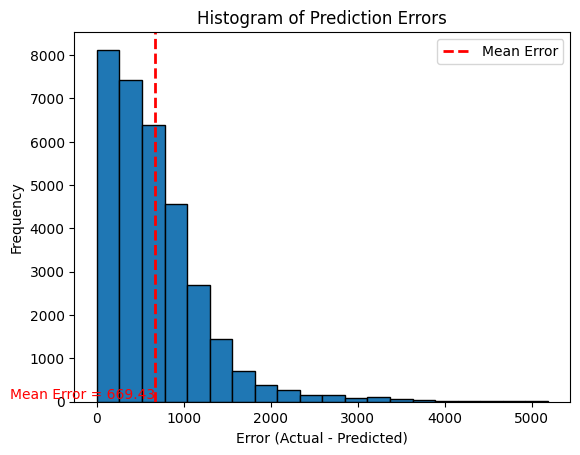

In [206]:
errors = abs(y_test - lasso_pred_test)
mean_error = np.mean(errors)
plt.hist(errors, bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.axvline(x=mean_error, color='red', linestyle='dashed', linewidth=2, label='Mean Error')
plt.text(mean_error, 5, f'Mean Error = {mean_error:.2f}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.legend()


In [207]:
parameters = rf_model.get_params()
for param, value in parameters.items():
    print(f"{param}: {value}")

bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 60
n_jobs: None
oob_score: False
random_state: 609
verbose: 0
warm_start: False


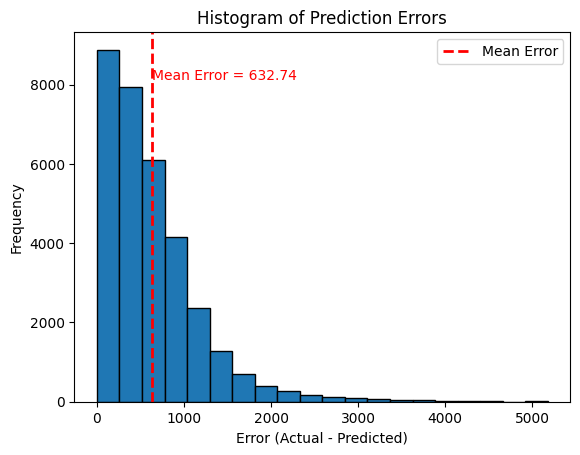

In [208]:
errors = abs(y_test - predictions)
mean_error = np.mean(errors)

plt.hist(errors, bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.axvline(x=mean_error, color='red', linestyle='dashed', linewidth=2, label='Mean Error')
plt.xlabel('Error (Actual - Predicted)')
plt.text(mean_error, plt.ylim()[1]*0.9, f'Mean Error = {mean_error:.2f}', color='red', verticalalignment='top', horizontalalignment='left')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.legend()
plt.show()

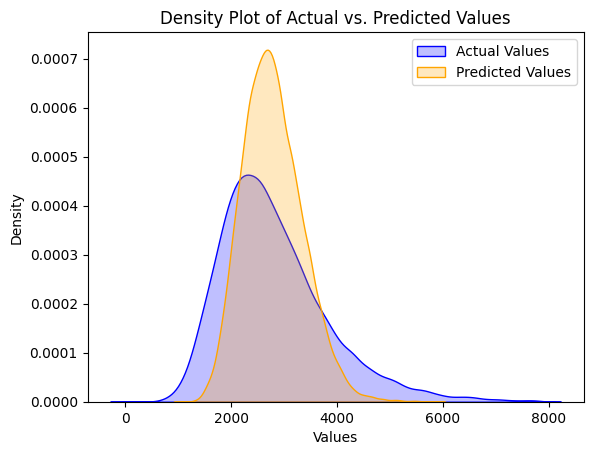

In [209]:
sns.kdeplot(y_test, label='Actual Values', color='blue', fill=True)
sns.kdeplot(predictions, label='Predicted Values', color='orange', fill=True)

plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Density Plot of Actual vs. Predicted Values')
plt.legend()
plt.show()


In [210]:
df.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'min_item_price', 'max_item_price', 'total_onshift_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'Delivery_time',
       'TimeOfDay_Afternoon', 'TimeOfDay_Late_Night', 'TimeOfDay_Morning',
       'TimeOfDay_Night'],
      dtype='object')

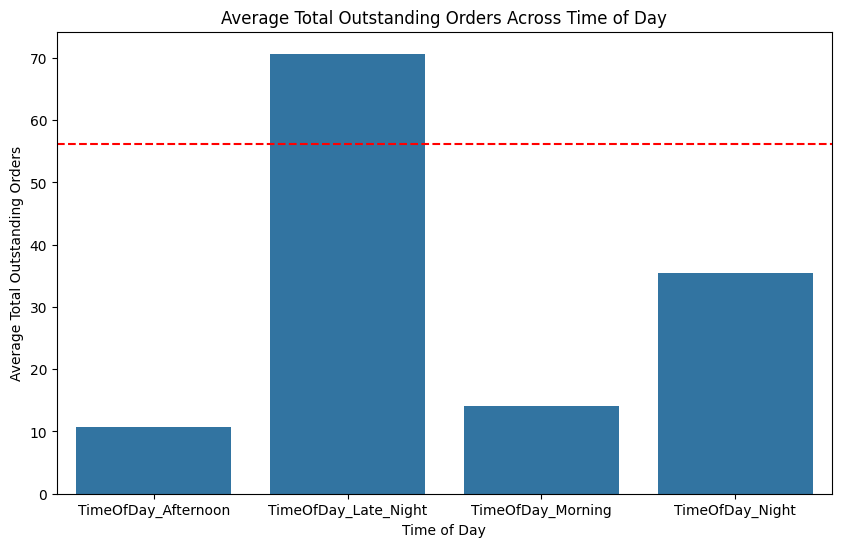

In [211]:
df_copy1 = df
df_copy1['TimeOfDay'] = df_copy1[['TimeOfDay_Afternoon', 'TimeOfDay_Late_Night', 'TimeOfDay_Morning', 'TimeOfDay_Night']].idxmax(axis=1)

# Calculate the average onshift dashers for each time of day
avg_onshift_dashers = df_copy1.groupby(['TimeOfDay']).agg({'total_outstanding_orders': 'mean'}).reset_index()
total_mean = df_copy1['total_outstanding_orders'].mean()

# Bar plot to show the average across times of day
plt.figure(figsize=(10, 6))
sns.barplot(x='TimeOfDay', y='total_outstanding_orders', data=avg_onshift_dashers, ci=None)  # ci=None removes error bars
plt.axhline(y=total_mean, color='red', linestyle='--', label='Total Mean')

plt.xlabel('Time of Day')
plt.ylabel('Average Total Outstanding Orders')
plt.title('Average Total Outstanding Orders Across Time of Day')
plt.show()


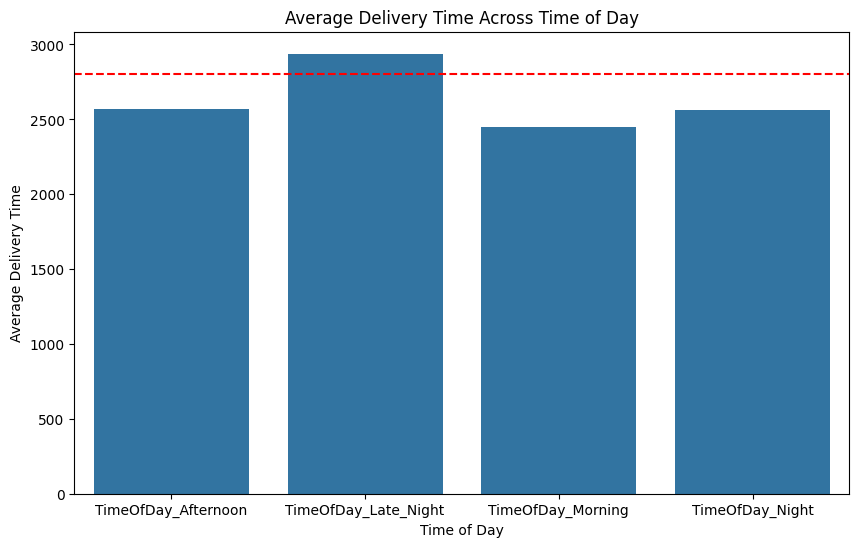

In [212]:

# Create a new column for Time of Day
df_copy1 = df
df_copy1['TimeOfDay'] = df_copy1[['TimeOfDay_Afternoon', 'TimeOfDay_Late_Night', 'TimeOfDay_Morning', 'TimeOfDay_Night']].idxmax(axis=1)

# Calculate the average onshift dashers for each time of day
avg_onshift_dashers = df_copy1.groupby(['TimeOfDay']).agg({'Delivery_time': 'mean'}).reset_index()
total_mean = df_copy1['Delivery_time'].mean()

# Bar plot to show the average across times of day
plt.figure(figsize=(10, 6))
sns.barplot(x='TimeOfDay', y='Delivery_time', data=avg_onshift_dashers, ci=None)  # ci=None removes error bars
plt.axhline(y=total_mean, color='red', linestyle='--', label='Total Mean')

plt.xlabel('Time of Day')
plt.ylabel('Average Delivery Time')
plt.title('Average Delivery Time Across Time of Day')
plt.show()


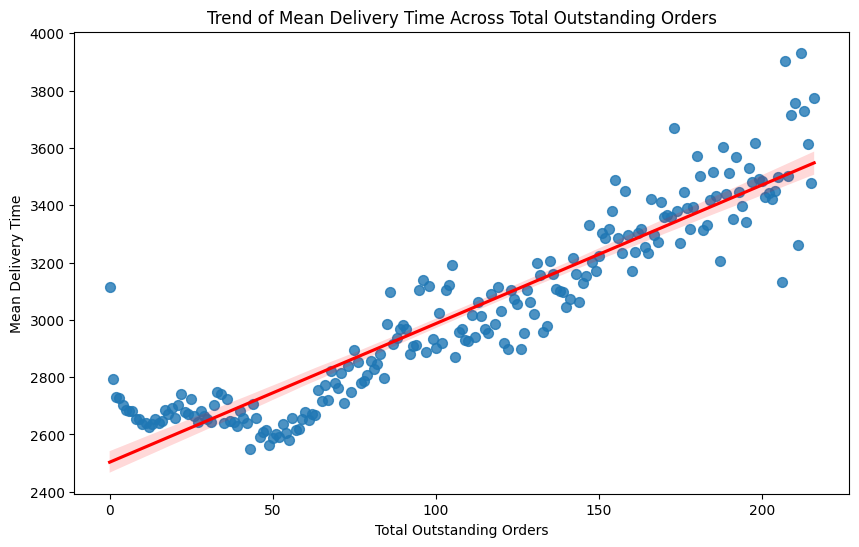

In [213]:
# Calculate the mean delivery time for each level of total outstanding orders
mean_delivery_time = df.groupby('total_outstanding_orders')['Delivery_time'].mean().reset_index()

# Line plot to show the trend
plt.figure(figsize=(10, 6))
sns.regplot(x='total_outstanding_orders', y='Delivery_time', data=mean_delivery_time, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.xlabel('Total Outstanding Orders')
plt.ylabel('Mean Delivery Time')
plt.title('Trend of Mean Delivery Time Across Total Outstanding Orders')
plt.show()


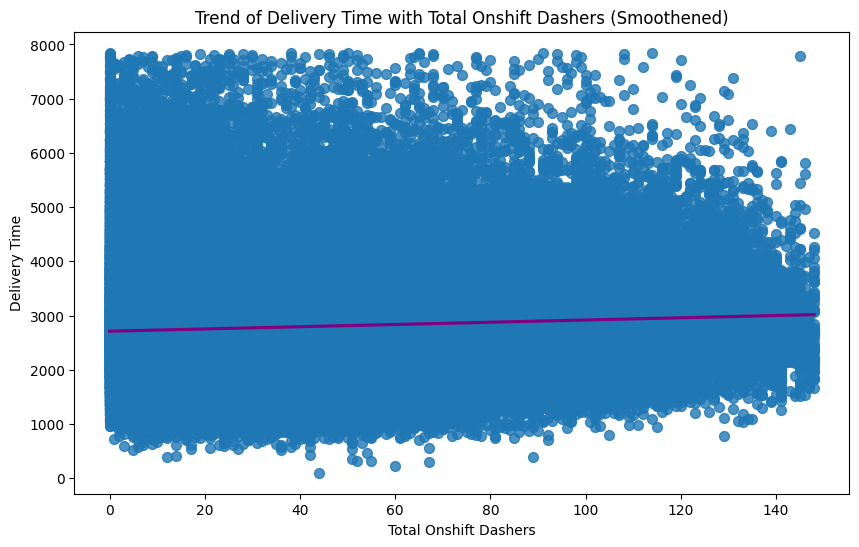

In [214]:
# Scatter plot with smoothened curve
plt.figure(figsize=(10, 6))
sns.regplot(x='total_onshift_dashers', y='Delivery_time', data=df, scatter_kws={'s': 50}, line_kws={'color': 'purple'})
plt.xlabel('Total Onshift Dashers')
plt.ylabel('Delivery Time')
plt.title('Trend of Delivery Time with Total Onshift Dashers (Smoothened)')
plt.show()
